Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", remove any ```raise NotImplementedError()``` and enter your student ID below:

STUDENT_ID = "200878566"

---

# MTH793P - Coursework 4

This is a template notebook for the computational exercises of [Coursework 4](https://qmplus.qmul.ac.uk/pluginfile.php/2462232/mod_resource/content/1/coursework06.pdf) of the module MTH793P, Advanced machine learning. Closely follow the instructions in this template in order to complete the assessment and to obtain full marks. For the submitted notebook, please only modify cells where you are instructed to do so. Failure to comply may result in unexpected errors that can lead to mark deductions.

Author: [Martin Benning](mailto:m.benning@qmul.ac.uk)

Date: 26.01.2021

As usual, we begin by loading the necessary libraries.

In [1]:
%matplotlib inline
from load_mnist import *
import numpy as np
import numpy.matlib
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%load_ext autoreload
%autoreload 2

We begin this week's coursework by loading the Old Faithful dataset with the following cell. The Old Faithful dataset is a well-known dataset in Statistics in Machine Learning. The data includes the waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA. The data can be described as follows:

     A data frame with 272 observations on 2 variables.

    eruptions  numeric  Eruption time in mins
    waiting    numeric  Waiting time to next eruption

For more information, please visit the following references:

     Hardle, W. (1991) Smoothing Techniques with Implementation in S.
     New York: Springer.

     Azzalini, A. and Bowman, A. W. (1990). A look at some data on the
     Old Faithful geyser. Applied Statistics 39, 357-365.

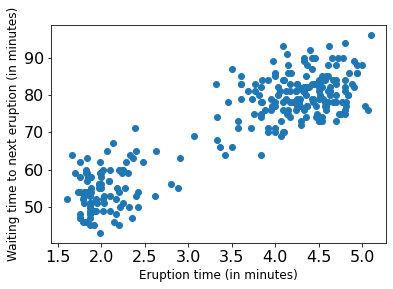

In [2]:
old_faithful_dataset = np.loadtxt("faithful.csv", delimiter=" ", skiprows=0)
plt.scatter(old_faithful_dataset[:, 0], old_faithful_dataset[:, 1])
plt.xlabel('Eruption time (in minutes)', fontsize=12)
plt.ylabel('Waiting time to next eruption (in minutes)', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout;

Similar to what has been shown in the lecture, we are going to implement $k$-means clustering to cluster the Old Faithful dataset into two clusters. Before we start any computations, we manually set a seed for the random number generator.

In [3]:
np.random.seed(13)

## K-means clustering

We write a function *k_means_clustering* that performs $k$-means clustering for input data *data* and a number of clusters *no_of_clusters* based on the alternating algorithm described in the lecture notes. Here *data* is matrix $X = \left( \begin{matrix} x_1^\top \\ \vdots \\ x_s^\top \end{matrix} \right) \in \mathbb{R}^{s \times d}$ of $s$ $d$-dimensional vectors. Optional arguments are the initialisation for the centroids *centroids*, the maximum number of iterations *maximum_counter*, the tolerance parameter *tolerance* for when the iteration is considered to have converged and the parameter *print_output* that determines after how many iterations a progress-update is printed. If *centroids* is set to None, initialise *centroids* as a 2D array of correct size with normal distributed random variables with mean zero and standard deviation one. Make sure that the algorithm stops as as soon as $\left(L(z^k, \mu^k) - L(z^{k + 1}, \mu^{k + 1})\right) / L(z^{k + 1}, \mu^{k + 1}) \leq \text{tolerance}$. Here, $L$ denotes the k-means clustering objective

$$ L(z, \mu) = \sum_{i = 1}^s \sum_{j = 1}^k z_{ij} \| x_i - \mu_j \|^2 \, . $$

Our function should return the centroids *centroids* and the assignments *assignments*. Here, *centroids* is a matrix $\mu = \left( \begin{matrix} \mu_1^\top \\ \vdots \\ \mu_k^\top \end{matrix} \right) \in \mathbb{R}^{k \times d}$ that contains all $k$ centroid vectors and *assignments* is a matrix $z \in \{0, 1\}^{s \times k}$ that contains the cluster assignments for each sample. Please feel free to make use of your pairwise distance function from [Coursework 2](https://qmplus.qmul.ac.uk/pluginfile.php/2546855/mod_resource/content/2/coursework2.pdf), or use the SciPy built-in function [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html).

In [4]:
Euclidean_Distance = lambda data,centroids: cdist(data, centroids)

In [5]:
def k_objective(data,no_of_clusters,Z,distance_matrix):
    L = 0
    for i in range(data.shape[0]):
        for j in range(no_of_clusters):
            L += Z[i,j] * distance_matrix[i,j]
    return L

In [6]:
def k_means_clustering(data, no_of_clusters, centroids=None, maximum_counter=300, tolerance=1e-9, \
                       print_output=10):
    s = data.shape[0]
    d = data.shape[1]
    k = no_of_clusters
    
    centroids_copy = centroids
    if centroids_copy is None:
        centroids_copy = np.random.normal(0,1,(k, d))
        
    objective_values = []
      
    for l in range(maximum_counter):
        #CALCULATING THE Z MATRIX
        distance_matrix = Euclidean_Distance(data,centroids_copy)
        z_matrix = np.zeros_like(distance_matrix)
        z_matrix[np.arange(len(distance_matrix)),distance_matrix.argmin(1)] = 1
        #CALCULATING THE NEW CENTROIDS
        new_centroids = np.zeros((k,d))
        for j in range(k):
            index = (z_matrix[:,j] == 1)
            index_length = len(data[index])
            if index_length == 0:
                index_length+= 1
            update_centroids = sum((data[index]))/index_length
            new_centroids[j] = update_centroids
        centroids_copy  = new_centroids
        #CALCULATING THE OBJECTIVE VALUES
        objective = lambda z_matrix: k_objective(data,k,z_matrix,distance_matrix)
        value = objective(z_matrix)
        objective_values.append(value)
        
        if len(objective_values) >= 2:
            
            if (objective_values[-2] - objective_values[-1])/objective_values[-1] < tolerance:
                print("Threshold has been exceeded after {it} iterations".format(it = l))
                return centroids_copy, z_matrix
            else:
                if (l % print_output) == 0: 

                    print("Iteration {c}/{m}, objective value = {o}".format(c = l, m = maximum_counter, \
                                                                   o = value))
            
           
    return centroids_copy, z_matrix


Cluster the Old Faithful dataset into two clusters and store the centroids in *centroids* and the assignments in *assignments*. Initialise your centroids with the two centroid vectors $\mu_1 = \left( \begin{matrix} 3.5 & 50\end{matrix}\right)^\top$ and $\mu_2 = \left( \begin{matrix} 3 & 80\end{matrix}\right)^\top$.

In [7]:
no_of_clusters = 2
initial_centroids = np.array([[3.5,50],[3,80]])
centroids, assignments = k_means_clustering(old_faithful_dataset,no_of_clusters,initial_centroids, print_output = 10)


Threshold has been exceeded after 2 iterations


Visualise your clustering results with the following lines of code.

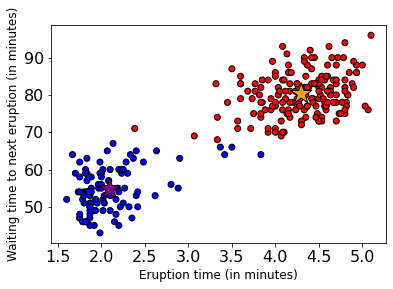

In [8]:
colormap_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(old_faithful_dataset[:, 0], old_faithful_dataset[:, 1], c=assignments[:, 0], cmap=colormap_bright, \
            edgecolors='k')
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", s=500, color=["purple", "orange"], edgecolors='k')
plt.xlabel('Eruption time (in minutes)', fontsize=12)
plt.ylabel('Waiting time to next eruption (in minutes)', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout;

Test your code with the following visible tests. The first test is worth **2/10 marks**, the second test is worth **3/10 marks**.

In [9]:
from numpy.testing import assert_array_almost_equal
test_data = np.array([-3, 2, -1, 7, 11, 6, -30, 0, -50, 15]).reshape(-1, 1)
test_centroids = np.array([-4, 0, 1]).reshape(-1, 1)
test_centroids, _ = k_means_clustering(test_data, 3, test_centroids, print_output=100)
assert_array_almost_equal(test_centroids, np.array([[-40], [-0.5], [9.75]]))

Threshold has been exceeded after 3 iterations


In [10]:
test_data = np.array([[-3, 2, -1, 7, 11], [6, -30, 0, -50, 15]]).T
test_centroids = np.array([[-1, 1], [3, -5], [10, 15]])
test_centroids, _ = k_means_clustering(test_data, 3, test_centroids, print_output=100)
assert_array_almost_equal(test_centroids, np.array([[-2, 3], [4.5, -40], [11, 15]]))

Threshold has been exceeded after 2 iterations


Do not write code into the following cells as they are place holders for test cells with hidden tests. Those tests are awarded **3/10 marks** in total.

We now repeat the previous exercise, but we standardise the data first. Write a function **standardise** that takes a data matrix _data_ as its input and that returns a matrix for which all columns have mean zero and standard deviation one.

In [11]:
def standardise(data):
    row_of_means = np.mean(data,axis = 0)
    standardised_matrix = data - row_of_means
    row_of_stds = np.std(standardised_matrix, axis = 0)
  
    return (standardised_matrix/row_of_stds)


Visualise your standardised data with the following cell.

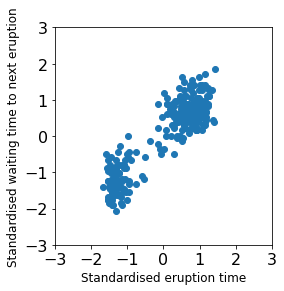

In [12]:
standardised_old_faithful_dataset = standardise(old_faithful_dataset)
plt.scatter(standardised_old_faithful_dataset[:, 0], standardised_old_faithful_dataset[:, 1])
plt.xlabel('Standardised eruption time', fontsize=12)
plt.ylabel('Standardised waiting time to next eruption', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
plt.tight_layout;

Compute the $k$-means clustering solution for $k = 2$ clusters for the standardised data *standardised_old_faithful_dataset* with initial centroids $\mu_1 = \left( \begin{matrix} -1.8 & 1.2\end{matrix}\right)^\top$ and $\mu_2 = \left( \begin{matrix} 1.8 & -1.7\end{matrix}\right)^\top$. Visualise your results in similar fashion as before. Do you spot any differences?

In [13]:
# YOUR CODE HERE
initial_centroids = np.array([[-1.8, 1.2],[1.8, -1.7]])
centroids, assignments = k_means_clustering(standardised_old_faithful_dataset,no_of_clusters,initial_centroids,\
                                            print_output = 10)

Threshold has been exceeded after 6 iterations


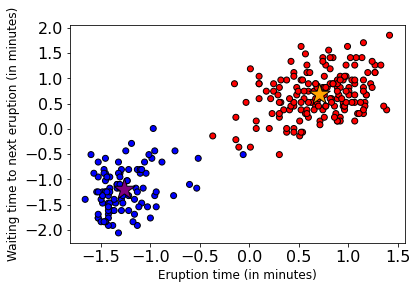

In [14]:
colormap_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(standardised_old_faithful_dataset[:, 0], standardised_old_faithful_dataset[:, 1], c=assignments[:, 0], cmap=colormap_bright, \
            edgecolors='k')
plt.scatter(centroids[:, 0], centroids[:, 1], marker="*", s=500, color=["purple", "orange"], edgecolors='k')
plt.xlabel('Eruption time (in minutes)', fontsize=12)
plt.ylabel('Waiting time to next eruption (in minutes)', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout;

Do not write code into the following cell as it is a place holder for a test cell with a hidden test that is worth **2/10 marks**.

## Fashion MNIST

We now repeat the clustering exercise with the Fashion MNIST data, to see how our unsupervised clusters compare to the actual clusters of this dataset. We load the (training) fashion MNIST dataset, which we have downloaded [here](https://github.com/zalandoresearch/fashion-mnist) prior to this exercise.

In [15]:
fashion_images, fashion_labels = load_mnist('FashionMNIST/')

As a little sanity check we visualise a sample of the dataset, together with the corresponding label and the size of the dataset.

Class label = 2, dataset dimension = 60000 x 784


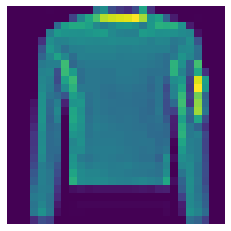

In [16]:
plt.imshow(np.reshape(fashion_images[3917, :], (28, 28)))
plt.axis('off')
print('Class label = %d, dataset dimension = %d x %d' %(fashion_labels[3917], fashion_images.shape[0], \
                                                            fashion_images.shape[1]))

Subsequently, we run the $k$-means clustering algorithm on the dataset *fashion_images* for 10 clusters. Please feel free to test the code for different numbers of clusters.

In [17]:
centroids, assignments = k_means_clustering(fashion_images, 10)

Threshold has been exceeded after 2 iterations


As a test, we visualise the computed centroids.

In [18]:
#NA

We compare these cluster centroids to the averages for each class.

In [19]:
def one_hot_vector_encoding(labels):
    a = labels
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b
print(one_hot_vector_encoding(fashion_labels).shape)

Average = str(np.mean(assignments == one_hot_vector_encoding(fashion_labels))*100) + "%"
print("The accuracy of the K means clustering algorithm is " + Average)

(60000, 10)
The accuracy of the K means clustering algorithm is 82.0%


We see that some cluster centres seem to (approximately) match the averages of the data points for individual classes, but we see that there are also substantial differences for some cluster centres compared to the average images. We now repeat the previous exercise, but we standardise the data first and store it in an array named *fashion_images_standardised*. Compute the centroids and assignments for the standardised data and store them in the variables *standardised_centroids* and *standardised_assignments*.

In [20]:
# YOUR CODE HERE
fashion_images_standardised = standardise(fashion_images)
standardised_centroids, standardised_assignments = k_means_clustering(fashion_images_standardised, 10)

Threshold has been exceeded after 10 iterations


Subsequently, we visualise the new centroids.

In [21]:
# YOUR CODE HERE
Average = str(np.mean(standardised_assignments == one_hot_vector_encoding(fashion_labels))*100) + "%"
print("The accuracy of the K means clustering algorithm is " + Average)

The accuracy of the K means clustering algorithm is 82.99033333333334%


## Colour compression

We condlude this coursework with another clustering application: the compression of colour images. An 8-bit RGB image can represent $256 = 2^8$ values per colour-channel. Suppose we would like to approximate such an image with an $n$-bit RGB image, where $n < 8$. How do we choose the $3 n$ colour-intensity values, so that the image looks similar to the original image? Your task is to show that this can be done with k-means clustering. First, we load an 8-bit test image and visualise it.

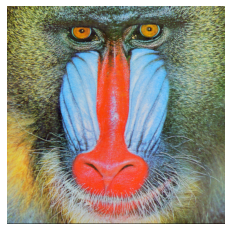

In [22]:
from skimage import io, img_as_float64
mandrill = img_as_float64(io.imread('mandrill.png'))
plt.imshow(mandrill)
plt.axis('off')
plt.tight_layout;

Apply k-means clustering to the Mandrill image. Set the number of clusters to $2^\text{no_of_bits}$, where *no_of_bits* is a variable between 1 and 8.

In [23]:
# YOUR CODE HERE
variable = [1,2,3,4,5,6,7,8]
no_of_clusters = 2**variable[3]
mandrill_reshaped = mandrill.reshape(-1,480)
centroids, assignments = k_means_clustering(mandrill_reshaped,no_of_clusters)

Iteration 10/300, objective value = 5126.984815931374
Iteration 20/300, objective value = 4829.756335500606
Iteration 30/300, objective value = 4771.9156150338285
Iteration 40/300, objective value = 4727.398088343539
Threshold has been exceeded after 44 iterations


Create an image that only uses the colours identified as centroids with k-means clustering algorithm and store it in a variable named *mandrill_approximation*.

In [24]:
#NA

Visualise your results in comparison to the original image.

In [25]:
#NA

This concludes this week's coursework.